# Analysis - cycle time data

Let's first define what _Cycle Time_ means or how it's defined for the purpose of this notebook:

__Cycle Time__:
  > "...the time between two items emerging from a process"

This notebook illustrates an analysis and forecasting for data based on _Cycle Time_ as defined above.
In particular the following aspects are considered:

* working days versus calendar days
* working hours versus 24h
* batches of deliveries or single items
* consistency with the 'Delivery Rate'
* noise in the data due to sloppy/faulty entry dates of the data

## Table of contents

* [Set-up](#Set-up)
* [Data and simulation set-up](#Data-and-simulation-set-up)
* [Data analysis](#Data-analysis)
* [Empirical CDF](#Empirical-CDF)
* [References](#References)

## Set-up

In [13]:
import Chi2fit.CSV
alias Chi2fit.Distribution, as: D
alias Chi2fit.Gnuplotlib, as: G
import Chi2fit.Statistics
import Chi2fit.Times
alias Chi2fit.Utilities, as: U
:"do not show this result in output"

## Data and simulation set-up

The data set (`team.csv`) consists of several hundreds of completed items in the span of 1 year. In this case the data is exported from [Jira](http://jira.atlassian.com). Here, we take as a completion date the resolution times.

In [3]:
#
# Completed items have a resolution date which is in the column "Resolved"
# Jira exports time data as shown above.
#
deliveries = "/app/notebooks/data/team.csv"
|> File.stream!
|> csv_to_list("Resolved", header?: true, format: "{0D}/{Mshort}/{YY} {h24}:{0m}")

IO.inspect(deliveries, print: false, limit: 3)
IO.puts "Number of completed items: #{length(deliveries)}"
:"do not show this result in output"

[~N[2019-05-13 13:03:00], ~N[2019-05-13 11:42:00], ~N[2019-05-13 09:24:00], ...]
Number of completed items: 879


First, we set some parameters that will be used later on in this notebook. Especially important for analyzing the data, is that we need to make a choice for how to handle:

* working days vs calendar days,
* working hours vs 24h,
* look at batches of deliveries or at single deliveries,
* decide on the size of a cluster of data for fitting to a known distribution.

In [8]:
##
## Data analysis
##

# Working hours: 8AM to 8PM
workhours = {8,20}

# Correct for working days and/or working hours (:weekday, :worktime, :"weekday+worktime")
correct = :"weekday+worktime"

# Cutoff for minimum amount of time between consecutive deliveries (15/12/60 corresponds to 15 minutes)
cutoff = 15/(12*60)

# Size of the bins to group the data (2/24 means a granularity of 2 hours)
binsize = 2/12
:"do not show this result in output"

In [5]:
{startofday,endofday} = workhours
hours_in_day = endofday - startofday
:"do not show this result in output"

In [6]:
# Cycle Times in number of calendar days
ctlist = deliveries
|> Stream.chunk_every(2, 1, :discard)
|> Stream.map(fn [d1,d2] -> NaiveDateTime.diff(d1,d2) end) # Calculate the time difference between two consecutive deliveries in seconds
|> Enum.map(& &1/24/3600) # Convert the number of seconds to number of days
IO.inspect(ctlist, print: false, limit: 3)
:"do not show this result in output"

[0.05625, 0.09583333333333334, 0.002777777777777778, ...]


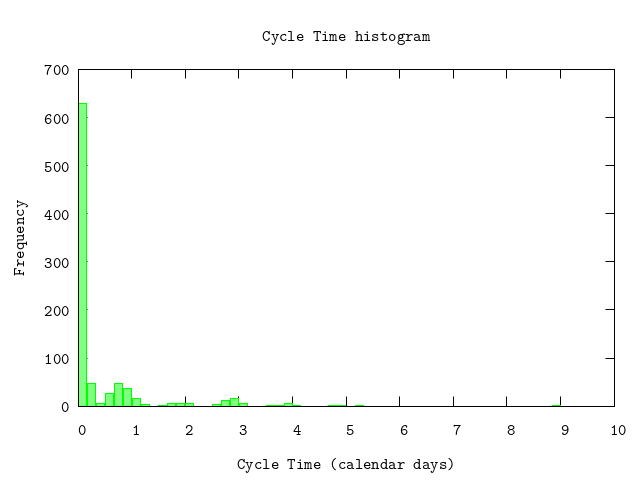

In [7]:
G.histogram(ctlist,
    bin: binsize,
    plottitle: "Cycle Time histogram",
    xlabel: "Cycle Time (calendar days)",
    ylabel: "Frequency",
    xrange: '[0:]')
:"this is an inline image"

The histogram shows some 'strange' humps. It could be due to so-called multi-modal data. Muti-modal means that the data has a 'preference' for certain values (= the humps) and usually corresponds to different types of work. However, it is more likely to becaused by patterns in the data which we may be able to correct for.

## Data analysis

On first site there appear to be bumps around _Cycle Times_ of a whole number of days. Second, between 0 and 1 the _Cycle Time_ exhibits a dip. There are two main factors that may be relevant and may explain this observed behaviour:

1. __Work hours__. Most people have regularised working hours somewhere between 8AM and 18PM depending on how early they start work,
1. __Weekdays__. People don't work during the weekends,
1. __Sloppy administration__. What often happens is that work has completed at some time of the day and instead of immediately registering the work as done, this often happens a couple of hours later, or the next day, or even at the end of an iteration (just before reporting).

First we will examine the first 2 factors. One way of handling the 3rd factor is to add a random noise to the completion dates and estimate the effect of this.

For now, we'll assume no noise.

In [11]:
#
# The noise to add to the delivery times to estimagte the error due to sloppy/faulty administration
#

# No noise
noise = fn -> 0.0 end

# Assume that in practice deliveries never are at exactly the same time. If so, then we'll further assume that
# this is due to 'sloppy' administration. When this happens we set the _Cycle Time_ to a certain minimum space
# between them (the cutoff)
fun = fn dat -> dat
  # Map the delivery times to numbers: the number of days since the epoch Jan 1st, 1970:
  |> Stream.map(& NaiveDateTime.diff(&1, ~N[1970-01-01 00:00:00], :second)/(24*3600))

  # Adjust the time for working hours: 8AM - 22PM
  # This maps the period of working hours to the interval 0..1
  |> adjust_times(correct: correct, workhours: workhours)

  # Apply noise to our data
  |> Stream.map(& &1+noise.())
  
  # Sort again to get properly ordered completeion dates
  |> Enum.sort(& &1>&2)
  
  # Calculate time differences with cut-off
  |> time_diff(cutoff: cutoff)
end
:"do not show this result in output"

Next, recalculate the _Cycle Times_ with the corrections specified above. This basically switches from _calendar days_ to _working days_.

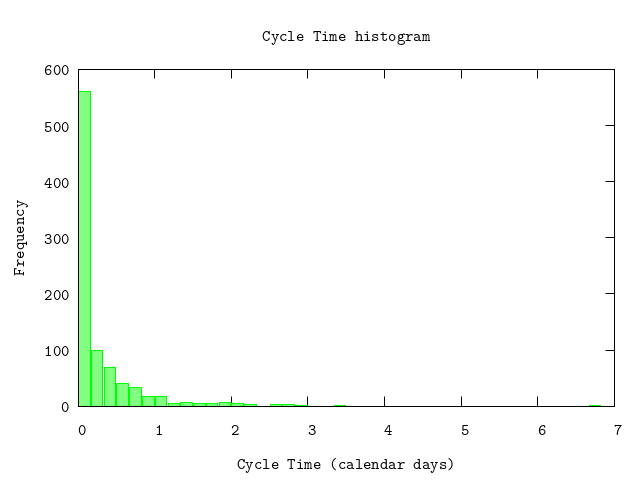

In [12]:
# Cycle Times in number of days
ctlist = deliveries
|> fun.()

ctlist |> G.histogram(
    bin: binsize,
    plottitle: "Cycle Time histogram",
    xlabel: "Cycle Time (calendar days)",
    ylabel: "Frequency",
    xrange: '[0:]')
:"this is an inline image"

The effect of the corrections is clearly visible in the chart:

* much more smoothened graph without significant bumps,
* no small bar to the left of the largest bar; this is caused by the cutoff.

We did not take into account public holidays so this could still introduce small bumps but we expect that this effect is 'within' the noise of the data.

## Empirical CDF

In [14]:
hdata = ctlist |> to_bins({binsize,0})
IO.puts "#{length(ctlist)} Cycle Times reduced to #{length(hdata)} bins"
:"do not show this result in output"

878 Cycle Times reduced to 19 bins


The data returned contains a list of tuples each describing a bin:
* the end-point of the bin,
* the proportional number of events for this bin (the total count is normalized to one),
* the lower value of the error bound,
* the upper value of the error bound.

As can be seen the sizes of the lower and upper bounds are different in value, i.e. they are asymmetrical. The contribution or weight to the likelihood function used in fitting known distributions will de different depending on whether the observed value if larger or smaller than the predicted value. This is specified by using the option `:linear` (see below). See [3] for details.

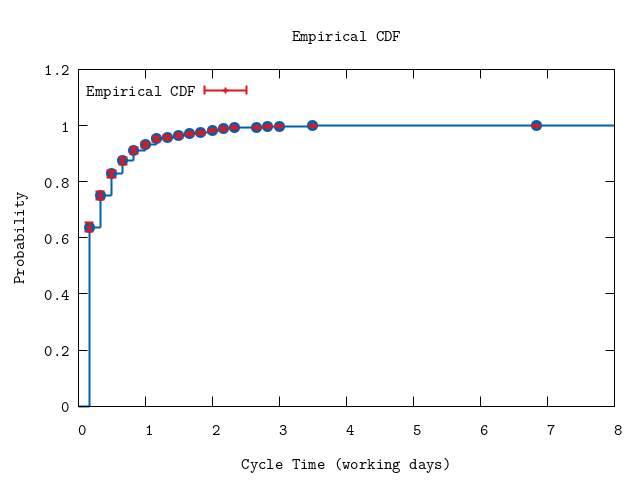

In [15]:
G.ecdf(hdata,
    plottitle: "Empirical CDF",
    xlabel: "Cycle Time (working days)",
    ylabel: "Probability",
    xrange: '[0:8]')
:"this is an inline image"

## References

[1] _Erlang distribution_, https://en.wikipedia.org/wiki/Erlang_distribution

[2]: _Chi2Fit_, Pieter Rijken, 2018, https://hex.pm/packages/chi2fit

[3]: _Asymmetric errors_, Roger Barlow, Manchester University, UK and Stanford University, USA, PHYSTAT2003, SLAC, Stanford, California, September 8-11, 2003, https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf

[4]: _Efficient use of Monte Carlo: uncertainty propagation_, D. Rochman et. al., Nuclear Science and Engineering, 2013, ftp://ftp.nrg.eu/pub/www/talys/bib_rochman/fastTMC.pdf